In [1]:
import os
import numpy
from scipy.misc import logsumexp
import tqdm
import pickle
import hom2m
import wendym2m
from galpy.util import bovy_plot, save_pickles
%pylab inline
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
numpy.random.seed(4)
import copy
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML, Image
import seaborn as sns
tc= sns.color_palette('colorblind')
init_color= sns.color_palette()[0]
final_color= tc[2]
constraint_color= tc[1]
save_figures= True
save_chain_figures= False

Populating the interactive namespace from numpy and matplotlib


# M2M with one-dimensional self-gravity

Here we investigate M2M with one-dimensional self-gravity (and optionally a constant density background).

## Mock observations

First we generate some mock observations for a self-gravitating isothermal disk (a $\mathrm{sech}^2$ disk).

In [2]:
n_mock= 100000
sigma_true= 0.1
totmass_true= 0.25
z_mock, vz_mock, m_mock= wendym2m.sample_sech2(sigma_true,totmass_true,n=n_mock)

The density looks like a $\mathrm{sech}^2$ disk (cored near the center, exponential at large distances):

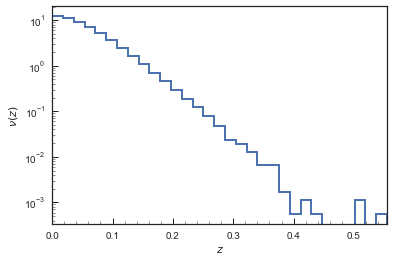

In [3]:
_= bovy_plot.bovy_hist(numpy.fabs(z_mock),bins=31,normed=True,
                       xlabel=r'$z$',ylabel=r'$\nu(z)$',lw=2.,histtype='step')
gca().set_yscale('log')

Now we 'observe' this density distribution from $z_{\mathrm{sun}} = 0.05$:

In [4]:
zsun_true= 0.05
# We only observe the density at a few z
z_obs= numpy.array([0.1,0.15,0.2,-0.1,-0.15,-0.2])
h_obs= 0.025
dens_obs= hom2m.compute_dens(z_mock,zsun_true,z_obs,h_obs,w=m_mock)
dens_obs_noise= numpy.sqrt(dens_obs)*0.2*numpy.sqrt(numpy.amax(dens_obs))\
    /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
dens_obs+= numpy.random.normal(size=dens_obs.shape)*dens_obs_noise

The observed density is:

<Container object of 3 artists>

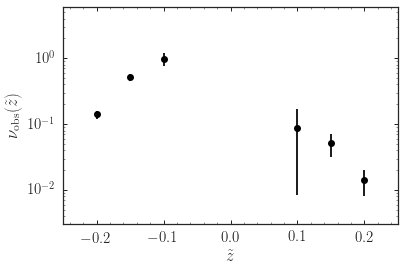

In [5]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,6.])
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean of the squared velocity:

In [6]:
# We only observe the v2 at a few z (same as before)
v2_obs= hom2m.compute_v2(z_mock,vz_mock,zsun_true,z_obs,h_obs)
# use constant noise
v2_obs_noise=numpy.zeros_like(v2_obs)+0.002
numpy.random.seed(10) # probably best to set a seed somewhere so the data is always the same
v2_obs+= numpy.random.normal(size=v2_obs.shape)*v2_obs_noise

<Container object of 3 artists>

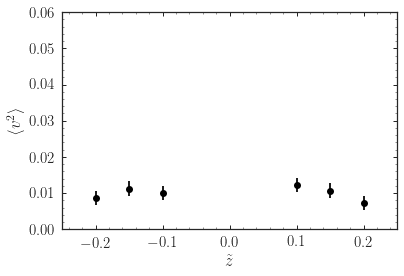

In [7]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v2_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0,0.06],gcf=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color='k')

Now we load all of this data into the ``data_dicts`` format for specifying the data for M2M:

In [8]:
dens_data= {'type':'dens','pops':0,'zobs':z_obs,'obs':dens_obs,'unc':dens_obs_noise,'zrange':1.}
v2_data= {'type':'v2','pops':0,'zobs':z_obs,'obs':v2_obs,'unc':v2_obs_noise,'zrange':1.}
data_dicts= [dens_data,v2_data]

## M2M fit

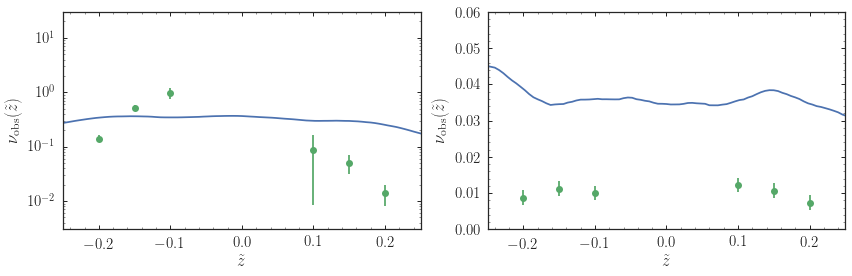

In [9]:
n_m2m= 1000
sigma_init= 0.2
h_m2m= 0.075
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_true,n=n_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_init= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.0,0.06])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
tight_layout()

Run without any smoothing:

In [10]:
step= numpy.pi/3.*10.**-2.
nstep= 10000
eps= 10.**-3.5
smooth= None#1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.075
omega_m2m= 0.
zsun_m2m= zsun_true
prior= 'entropy'
use_v2=True
w_out,z_m2m,vz_m2m,Q,wevol,windx= \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=10)
w_out= w_out[:,0]

Velocity dispersions: mock, fit 0.100209864033 0.093935396168


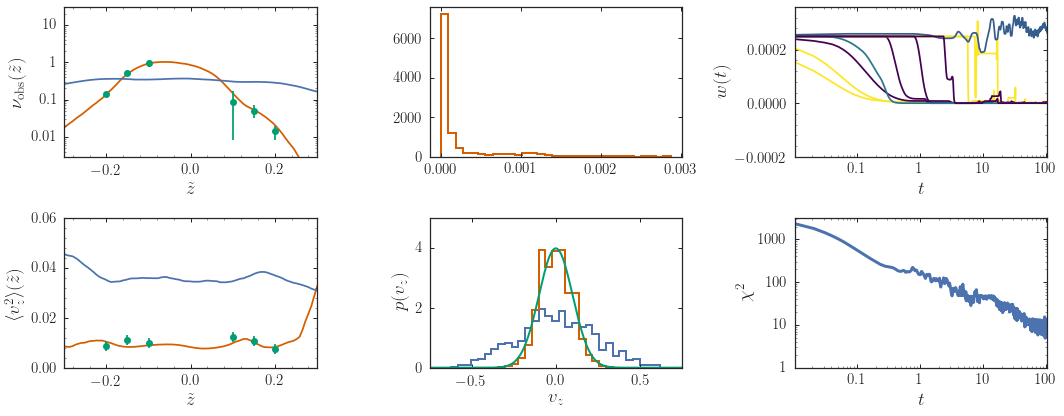

In [11]:
z_out= numpy.linspace(-0.35,0.35,101)
dens_final= hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.3,0.3],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[-.3,0.3],yrange=[0.0,0.06],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
#_= hist(w_init,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
_= hist(w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(-0.75,0.75,201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(-0.75,0.75)
ylim(0.,5.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
                        color=cm.viridis(z_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**3.5])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()